# London Nitrogen Dioxide

In this lab, we will be doing 1-step prediction of nitrogen dioxide levels in London. The data collection and deep model pre-processing is done for you.

## Data Collection

We begin by reading in the data. This time, we read from a Google Drive link.

In [1]:
import requests
import sys
import io
# if sys.version_info[0] < 3: 
#     from StringIO import StringIO
# else:
#     from io import StringIO
import pandas as pd

def download_file_from_google_drive(id):
    URL = "https://docs.google.com/uc?export=download"

    session = requests.Session()

    response = session.get(URL, params = { 'id' : id }, stream = True)
    return pd.read_csv(
        io.BytesIO(response.content),
        sep=',',
        infer_datetime_format=True,
        parse_dates=['datetime'],
        index_col=['datetime']
      ) 


In [2]:
file_id = '1ol5_p3vanKOW-i9bxQEV2pfiBDYByUVy'
df = download_file_from_google_drive(file_id)
df = df.drop(['month', 'dayofmonth', 'dayofweek'], axis=1) 

Let's take some time to examine the data! The data consists of times and NO2 
concentrations in ppm.



In [3]:
df.head()

,no2
datetime,
2013-01-01 00:00:00,27.479618
2013-01-01 01:00:00,30.396857
2013-01-01 02:00:00,20.696476
2013-01-01 03:00:00,27.172487
2013-01-01 04:00:00,25.197023


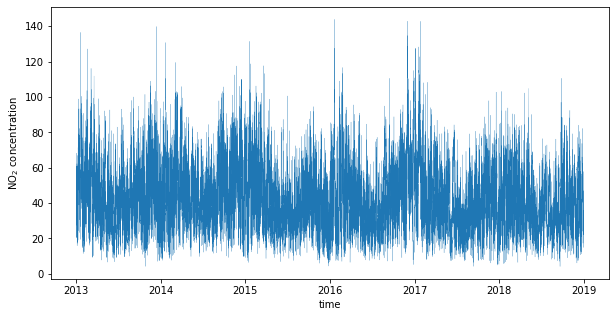

In [4]:
import matplotlib.pyplot as plt

plt.figure(figsize=(10, 5))
plt.plot(df['no2'], linewidth=0.2)
plt.xlabel('time')
plt.ylabel('$\mathrm{NO}_2$ concentration')
plt.show()

In [5]:
HORIZON=1  # future prediction

## Baselines (Task 1)

Start by implementing some baselines below!

In [6]:
# Task 1: Implement at least 1 baseline!

## Deep Learning Models (Task 2)

Next, we implement our models. We begin by extracting the training data.

In [7]:
from sklearn.preprocessing import MinMaxScaler
import numpy as np

# Starting dates for validation and test sets.
val_start = '2018-09-01 00:00:00' 
test_start = '2018-11-01 00:00:00' 

# Compute train data.
train = df.copy()[df.index < val_start][['no2']]
    
# Scale values to [0, 1].
scaler = MinMaxScaler()
train['no2'] = scaler.fit_transform(train)

# Shift the dataframe to create the answers
train_shifted = train.copy()
train_shifted['y_t+1'] = train_shifted['no2'].shift(-1 * HORIZON, freq='H')

# We create columns shifting each of the previous values forwards.
# This has the effect of giving us the history for each y-value in each row.
T = 24 # previous steps included 
for t in range(1, T+1):
    train_shifted[str(T-t)] = train_shifted['no2'].shift(T-t, freq='H')

# Renaming the columns, for convenience.
y_col = 'y_t+1'
X_cols = []
for i in range(T - 1,0,-1): 
  X_cols.append('load_t-' + str(i))
X_cols.append('load_t')
train_shifted.columns = ['load_original'] + [y_col] + X_cols

# Discard any samples with missing values
# Note: remember, shifting can cause missing values in the end/beginning
train_shifted = train_shifted.dropna(how='any')

# Transform into Numpy arrays
y_train = train_shifted[y_col].to_numpy()
X_train = train_shifted[X_cols].to_numpy()
X_train = X_train.reshape(X_train.shape[0], T, 1)

print(y_train[0:1], X_train[0:1, :])

[0.29864855] [[[0.16656332]
  [0.18744474]
  [0.11801003]
  [0.1643649 ]
  [0.15022466]
  [0.15736525]
  [0.18405688]
  [0.23040444]
  [0.25365992]
  [0.22764196]
  [0.21795929]
  [0.19576671]
  [0.18737115]
  [0.16915539]
  [0.17525708]
  [0.24550331]
  [0.35780512]
  [0.40575577]
  [0.37809956]
  [0.34520313]
  [0.33980849]
  [0.35240738]
  [0.34272319]
  [0.32705935]]]


We're going to do similar processing to get our validation set.

In [8]:
import datetime as dt

# Get the validation data from the correct data range
val_start_dt = dt.datetime.strptime(val_start, '%Y-%m-%d %H:%M:%S')
look_back_dt = val_start_dt - dt.timedelta(hours=T-1)
valid = df.copy()[(df.index >=look_back_dt) & (df.index < test_start)][['no2']]

# Scale the series using the transformer fitted on the training set:
valid['no2'] = scaler.transform(valid)

# Shift the dataframe to create the input samples
valid_shifted = valid.copy()
valid_shifted['y+1'] = valid_shifted['no2'].shift(-1 * HORIZON, freq='H')

# Create columns for every other shift
for t in range(1, T+1):
    valid_shifted['no2_t-'+str(T-t)] = valid_shifted['no2'].shift(T-t, freq='H')

# Discard any samples with missing values
valid_shifted = valid_shifted.dropna(how='any')

# Transform into Numpy arrays
y_valid = valid_shifted['y+1'].to_numpy()
X_valid = valid_shifted[['no2_t-'+str(T-t) for t in range(1, T+1)]].to_numpy()
X_valid = X_valid.reshape(X_valid.shape[0], T, 1)

print(y_valid[0:1], X_valid[0:1, :])

[0.32633036] [[[0.19337953]
  [0.16800101]
  [0.17337258]
  [0.18706051]
  [0.26946549]
  [0.30725807]
  [0.29932585]
  [0.2840193 ]
  [0.27648529]
  [0.2620929 ]
  [0.26010866]
  [0.2203306 ]
  [0.20665761]
  [0.23644781]
  [0.26642563]
  [0.31032195]
  [0.33973918]
  [0.3116203 ]
  [0.33567982]
  [0.35862117]
  [0.39531716]
  [0.38520647]
  [0.37060336]
  [0.3436311 ]]]


It's time to build our model.

In [9]:
import tensorflow
from tensorflow.keras.models import Model, Sequential
from tensorflow.keras.layers import LSTM, GRU, Dense, Activation, SimpleRNN
from tensorflow.keras.callbacks import EarlyStopping
from tensorflow.keras.utils import plot_model

# Task 2: Improve this model as much as possible! Consider changing the 
#         the hyperparameters below as well as the actual architecture.
#         Note: you can compare based on the validation loss (which is printed
#               during training)

# Hyperparameter "control panel"
LATENT_DIM = 20
BATCH_SIZE = 32
EPOCHS = 1
ACTIVATION_HIDDEN = None
ACTIVATION_OUT = None
OPTIMIZER = 'RMSProp'

# Model creation.
model = Sequential()
model.add(SimpleRNN(LATENT_DIM, activation=ACTIVATION_HIDDEN, input_shape=(T, 1)))
model.add(Dense(HORIZON, activation=ACTIVATION_OUT))
model.compile(optimizer=OPTIMIZER, loss='mse')
early_stop = EarlyStopping(monitor='val_loss', min_delta=0, patience=7)

model.summary()

Model: "sequential"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
simple_rnn (SimpleRNN)       (None, 20)                440       
_________________________________________________________________
dense (Dense)                (None, 1)                 21        
Total params: 461
Trainable params: 461
Non-trainable params: 0
_________________________________________________________________


In [10]:
history = model.fit(
  X_train,
  y_train,
  batch_size=BATCH_SIZE,
  epochs=EPOCHS,
  validation_data=(X_valid, y_valid),
  callbacks=[early_stop],
  verbose=1
)

1547/1547 [==============================] - 7s 4ms/step - loss: 0.0043 - val_loss: 0.0011


## Analysis

In [11]:
# Extract the test set.
test_start = '2018-11-01 00:00:00'
test_start_dt = dt.datetime.strptime(test_start, '%Y-%m-%d %H:%M:%S')
look_back_dt = test_start_dt - dt.timedelta(hours=T-1)
test = df.copy()[test_start_dt:][['no2']]

# Scale the data for input to model.
test['no2'] = scaler.transform(test)

# Shift the dataframe to create the input samples
test_shifted = test.copy()
test_shifted['y_t+1'] = test_shifted['no2'].shift(-1, freq='H')

# Shift forward to get history.
for t in range(1, T+1):
    test_shifted['no2_t-'+str(T-t)] = test_shifted['no2'].shift(T-t, freq='H')

# Discard any samples with missing values
test_shifted = test_shifted.dropna(how='any')

# Transform into a Numpy array
y_test = test_shifted['y_t+1'].to_numpy()
X_test = test_shifted[['no2_t-'+str(T-t) for t in range(1, T+1)]].to_numpy()
X_test = X_test.reshape(X_test.shape[0], T, 1)

# Predict!
predictions = model.predict(X_test)

# Convert back into a Pandas dataframe
eval_df = pd.DataFrame(predictions, columns=[' + ' + str(t) + ' hour(s) Prediction' for t in range(1, HORIZON+1)])
eval_df['timestamp'] = test_shifted.index
eval_df = pd.melt(eval_df, id_vars='timestamp', value_name='Predicted', var_name='h')
eval_df['True'] = np.transpose(y_test).ravel()
eval_df[['Predicted', 'True']] = scaler.inverse_transform(eval_df[['Predicted', 'True']])  
eval_df.head()

,timestamp,h,Predicted,True
0,2018-11-01 23:00:00,+ 1 hour(s) Prediction,52.044854,52.020389
1,2018-11-02 00:00:00,+ 1 hour(s) Prediction,45.205789,49.307734
2,2018-11-02 01:00:00,+ 1 hour(s) Prediction,45.040326,42.738605
3,2018-11-02 02:00:00,+ 1 hour(s) Prediction,38.462333,41.096738
4,2018-11-02 03:00:00,+ 1 hour(s) Prediction,40.885704,40.568923


In [12]:
model.evaluate(X_test, y_test)

45/45 [==============================] - 0s 2ms/step - loss: 8.1665e-04


0.0008166484767571092

Text(0, 0.5, '$\\mathrm{NO}_2$ concentration')

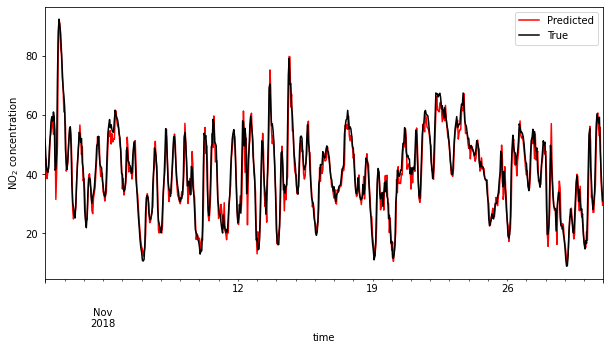

In [14]:
eval_df[eval_df.timestamp<'2018-12-01'].plot(x='timestamp', y=['Predicted', 'True'], style=['r', 'k'], figsize=(10, 5))
plt.xlabel('time')
plt.ylabel('$\mathrm{NO}_2$ concentration')

## Task 3

**Task 3.** Predicting the next hour was actually pretty easy. Next, increase the horizon of your prediction to predict 6 hours in the future. Re-run your baseline and deep learning model. How well can you do?